In [58]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
from matplotlib import pyplot as plt

In [30]:
import imageio
from IPython.display import Image, display

In [13]:
!pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 7.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [35]:
# Define a simple CNN that outputs Q-values for each action
class CartPoleCNN(nn.Module):
    def __init__(self, num_actions):
        super(CartPoleCNN, self).__init__()
        # Note: The convolutional architecture may need adjustment based on the image dimensions.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, num_actions)
    
    def forward(self, x):
        # x is expected to have shape (batch, channels, height, width)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Replay Buffer for storing transitions
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

# Helper function to preprocess an image from the environment.
def preprocess_image(image, device):
    # Convert image from HxWxC (RGB) to CxHxW and scale pixel values to [0, 1].
    image = np.transpose(image, (2, 0, 1)).astype(np.float32) / 255.0
    tensor = torch.from_numpy(image).unsqueeze(0).to(device)  # add batch dimension
    return tensor

def train_dqn():
    # Set up device and environment
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    num_actions = env.action_space.n

    # Initialize policy and target networks
    policy_net = CartPoleCNN(num_actions).to(device)
    target_net = CartPoleCNN(num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()  # target network in inference mode

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    replay_buffer = ReplayBuffer(capacity=10000)

    # Hyperparameters
    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay = 500  # decay factor for epsilon
    total_steps = 0
    num_episodes = 500
    target_update_interval = 10  # update target network every N episodes

    for episode in range(num_episodes):
        # Reset the environment and get the initial image state.
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            obs, _ = reset_result
        else:
            obs = reset_result
        # We use the rendered image as our state.
        state_img = env.render()
        state = preprocess_image(state_img, device)
        episode_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection.
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1.0 * total_steps / epsilon_decay)
            total_steps += 1
            if random.random() < epsilon:
                action = random.randrange(num_actions)
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = q_values.argmax().item()

            # Take a step in the environment.
            step_result = env.step(action)
            if len(step_result) == 5:
                _, reward, done, truncated, _ = step_result
                done = done or truncated
            else:
                _, reward, done, _ = step_result

            # Get next state as an image and preprocess it.
            next_state_img = env.render()
            next_state = preprocess_image(next_state_img, device)
            
            # Save transition in replay buffer.
            replay_buffer.push(state, action, reward, next_state, done)
            
            state = next_state
            episode_reward += reward

            # Perform training only if we have enough transitions.
            if len(replay_buffer) >= batch_size:
                print(replay_buffer.sample(batch_size))
                states_np, actions_np, rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)
                
                # The states and next_states are stored as numpy arrays of tensors.
                # We need to concatenate them along the batch dimension.
                states = torch.cat(list(states_np)).to(device)  # shape: (batch, C, H, W)
                actions = torch.tensor(actions_np, device=device).unsqueeze(1)  # shape: (batch, 1)
                rewards = torch.tensor(rewards_np, device=device, dtype=torch.float32).unsqueeze(1)
                next_states = torch.cat(list(next_states_np)).to(device)
                dones = torch.tensor(dones_np, device=device, dtype=torch.float32).unsqueeze(1)
                
                # Compute current Q-values from policy network.
                current_q_values = policy_net(states).gather(1, actions)
                
                # Compute target Q-values using the target network.
                with torch.no_grad():
                    max_next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                    target_q_values = rewards + gamma * max_next_q_values * (1 - dones)
                
                # Compute loss and update the policy network.
                loss = nn.MSELoss()(current_q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update the target network every few episodes.
        if episode % target_update_interval == 0:
            target_net.load_state_dict(policy_net.state_dict())
        print(f"Episode {episode} Reward: {episode_reward:.2f} Epsilon: {epsilon:.2f}")

    env.close()
    torch.save(policy_net.state_dict(), "dqn_cartpole.pth")
    print("Training finished and model saved as dqn_cartpole.pth")

In [38]:
# Set up device and environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode="rgb_array")
num_actions = env.action_space.n

# Initialize policy and target networks
policy_net = CartPoleCNN(num_actions).to(device)
target_net = CartPoleCNN(num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # target network in inference mode

optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(capacity=10000)

# Hyperparameters
batch_size = 32
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 500  # decay factor for epsilon
total_steps = 0
num_episodes = 500
target_update_interval = 10  # update target network every N episodes

for episode in range(num_episodes):
    # Reset the environment and get the initial image state.
    reset_result = env.reset()
    if isinstance(reset_result, tuple):
        obs, _ = reset_result
    else:
        obs = reset_result
    # We use the rendered image as our state.
    state_img = env.render()
    state = preprocess_image(state_img, device)
    episode_reward = 0
    done = False

    while not done:
        # Epsilon-greedy action selection.
        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1.0 * total_steps / epsilon_decay)
        total_steps += 1
        if random.random() < epsilon:
            action = random.randrange(num_actions)
        else:
            with torch.no_grad():
                q_values = policy_net(state)
                action = q_values.argmax().item()

        # Take a step in the environment.
        step_result = env.step(action)
        if len(step_result) == 5:
            _, reward, done, truncated, _ = step_result
            done = done or truncated
        else:
            _, reward, done, _ = step_result

        # Get next state as an image and preprocess it.
        next_state_img = env.render()
        next_state = preprocess_image(next_state_img, device)
        
        # Save transition in replay buffer.
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward

        # Perform training only if we have enough transitions.
        if len(replay_buffer) >= batch_size:
            print(replay_buffer.sample(batch_size))
            states_np, actions_np, rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)
            
            # The states and next_states are stored as numpy arrays of tensors.
            # We need to concatenate them along the batch dimension.
            states = torch.cat(list(states_np)).to(device)  # shape: (batch, C, H, W)
            actions = torch.tensor(actions_np, device=device).unsqueeze(1)  # shape: (batch, 1)
            rewards = torch.tensor(rewards_np, device=device, dtype=torch.float32).unsqueeze(1)
            next_states = torch.cat(list(next_states_np)).to(device)
            dones = torch.tensor(dones_np, device=device, dtype=torch.float32).unsqueeze(1)
            
            # Compute current Q-values from policy network.
            current_q_values = policy_net(states).gather(1, actions)
            
            # Compute target Q-values using the target network.
            with torch.no_grad():
                max_next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
                target_q_values = rewards + gamma * max_next_q_values * (1 - dones)
            
            # Compute loss and update the policy network.
            loss = nn.MSELoss()(current_q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Update the target network every few episodes.
    if episode % target_update_interval == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode} Reward: {episode_reward:.2f} Epsilon: {epsilon:.2f}")

env.close()
torch.save(policy_net.state_dict(), "dqn_cartpole.pth")
print("Training finished and model saved as dqn_cartpole.pth")

Episode 0 Reward: 13.00 Epsilon: 0.98
Episode 1 Reward: 15.00 Epsilon: 0.95


/tmp/ipykernel_30/247220065.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  state, action, reward, next_state, done = map(np.array, zip(*batch))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.

In [52]:
print(replay_buffer.buffer[0][0][0][0][0])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [69]:
next_state_img = np.transpose(next_state_img, (2, 0, 1)).astype(np.float32) / 255.0
tensor = torch.from_numpy(next_state_img).unsqueeze(0).to(device)  # add batch dimension
tensor

tensor([[[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

         ...,

         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.00

In [26]:
# Main function that runs the simulation, collects frames, and displays a GIF
def run_cartpole_cnn_gif():
    # Set up device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create the CartPole environment with render_mode 'rgb_array'
    env = gym.make("CartPole-v1", render_mode='rgb_array')
    num_actions = env.action_space.n

    # Initialize the CNN model
    model = CartPoleCNN(num_actions).to(device)
    
    # Optionally, load a pretrained model:
    # model.load_state_dict(torch.load("cartpole_cnn.pth"))
    
    frames = []  # List to store frames for the GIF
    reset_result = env.reset()
    
    # For gym versions >=0.26, reset returns (observation, info)
    if isinstance(reset_result, tuple):
        obs, info = reset_result
    else:
        obs = reset_result

    done = False
    total_reward = 0

    while not done:
        # Capture the current frame from the environment
        frame = env.render()  # returns an RGB numpy array
        frames.append(frame)
        
        # Use the CNN to predict an action from the image
        action = get_action_from_image(model, frame, device)
        
        # Take the action in the environment
        step_result = env.step(action)
        # Handle different return signatures for gym versions
        if len(step_result) == 5:
            obs, reward, done, truncated, info = step_result
            done = done or truncated
        else:
            obs, reward, done, info = step_result
        
        total_reward += reward

    env.close()
    print("Episode finished with total reward:", total_reward)
    
    # Save the collected frames as a GIF
    gif_filename = 'cartpole_simulation.gif'
    # Adjust fps (frames per second) as needed for your simulation speed
    imageio.mimsave(gif_filename, frames, fps=3)
    
    # Display the GIF inline in the Jupyter Notebook
    display(Image(filename=gif_filename))

Episode finished with total reward: 10.0


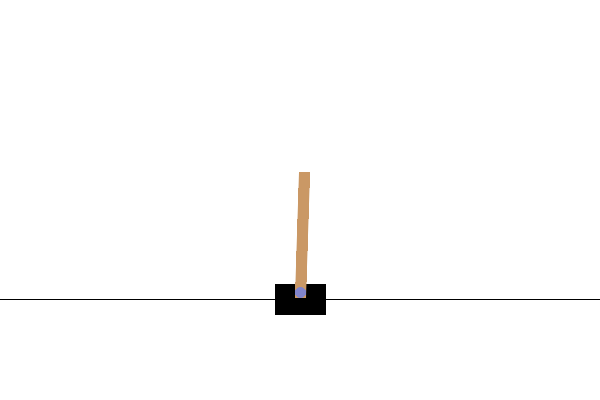

In [28]:
run_cartpole_cnn_gif()

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
import cv2

class CartPoleAgent:
    def __init__(self):
        self.model = self.build_cnn_model()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    def build_cnn_model(self):
        """
        Builds a CNN with the following architecture:
        
        Input: (4, 160, 240)  [channels_first]
        Conv2D: 64 filters, kernel_size=5, strides=(3,3), relu activation -> Output: (64, 52, 79)
        Conv2D: 64 filters, kernel_size=4, strides=(2,2), relu activation -> Output: (64, 25, 38)
        Conv2D: 64 filters, kernel_size=3, strides=(1,1), relu activation -> Output: (64, 23, 36)
        Flatten: -> 52992 units
        Dense: 512 units, relu activation
        Dense: 256 units, relu activation
        Dense: 64 units, relu activation
        Dense: 2 units, softmax activation
        """
        # Note: Using channels_first (i.e. (channels, height, width))
        input_shape = (4, 160, 240)
        inputs = Input(shape=input_shape)
        
        # First convolutional layer
        x = Conv2D(64, kernel_size=5, strides=(3, 3), activation='relu',
                   data_format='channels_first')(inputs)  # Output: (64, 52, 79)
        # Second convolutional layer
        x = Conv2D(64, kernel_size=4, strides=(2, 2), activation='relu',
                   data_format='channels_first')(x)       # Output: (64, 25, 38)
        # Third convolutional layer
        x = Conv2D(64, kernel_size=3, strides=(1, 1), activation='relu',
                   data_format='channels_first')(x)       # Output: (64, 23, 36)
        
        # Flatten and fully connected layers
        x = Flatten()(x)                                  # 52992 units
        x = Dense(512, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        outputs = Dense(2, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs, name="cnn model")
        return model
    
    def train_classifier(self, X_train, y_train, batch_size=32, epochs=10):
        """
        Trains the CNN classifier using the provided training data.
        Training will run on GPU if available.
        
        Parameters:
            X_train: Training images with shape (num_samples, 4, 160, 240)
            y_train: One-hot encoded labels with shape (num_samples, 2)
            batch_size: Batch size for training
            epochs: Number of epochs to train
        """
        # Determine if a GPU is available and set the appropriate device.
        if tf.config.list_physical_devices('GPU'):
            device = '/GPU:0'
        else:
            device = '/CPU:0'
        
        # Training within the device scope to leverage GPU acceleration if possible
        with tf.device(device):
            self.model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
    
    def process_rendered_image(self, image):
        """
        Compresses the rendered image by converting it to grayscale (if necessary)
        and resizing it to 240x160.
        
        Parameters:
            image: The input image from the environment.
            
        Returns:
            The processed image.
        """
        # If the image has three channels (e.g., BGR), convert it to grayscale.
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the image to (240, 160)
        image = cv2.resize(image, (240, 160))
        return image


ModuleNotFoundError: No module named 'tensorflow'

In [72]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import cv2
import gym
import imageio
import numpy as np

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Input shape: (batch, 4, 160, 240)
        # First Conv2D: 64 filters, kernel_size=5, stride=3 -> output: (64, 52, 79)
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=5, stride=3)
        # Second Conv2D: 64 filters, kernel_size=4, stride=2 -> output: (64, 25, 38)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2)
        # Third Conv2D: 64 filters, kernel_size=3, stride=1 -> output: (64, 23, 36)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        # Flatten size = 64 * 23 * 36 = 52992
        self.fc1 = nn.Linear(64 * 23 * 36, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 2)  # 2 output classes

    def forward(self, x):
        # Pass through convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))   # -> (batch, 64, 52, 79)
        x = F.relu(self.conv2(x))   # -> (batch, 64, 25, 38)
        x = F.relu(self.conv3(x))   # -> (batch, 64, 23, 36)
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # Output logits; for classification, use CrossEntropyLoss
        return x

class CartPoleAgent:
    def __init__(self):
        # Set device to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = CNNClassifier().to(self.device)
    
    def train_classifier(self, X_train, y_train, batch_size=32, epochs=10, learning_rate=1e-3):
        """
        Trains the CNN classifier using the provided training data.
        
        Parameters:
            X_train: Training images of shape (num_samples, 4, 160, 240) (numpy array or torch tensor)
            y_train: One-hot encoded labels of shape (num_samples, 2) (numpy array or torch tensor)
                     (they will be converted to class indices)
            batch_size: Batch size for training
            epochs: Number of epochs
            learning_rate: Learning rate for the optimizer
        """
        # Convert to torch tensors if necessary
        if isinstance(X_train, np.ndarray):
            X_train = torch.tensor(X_train, dtype=torch.float32)
        if isinstance(y_train, np.ndarray):
            y_train = torch.tensor(y_train, dtype=torch.float32)
        
        # Convert one-hot encoded labels to class indices
        if y_train.ndim == 2 and y_train.size(1) == 2:
            y_train = torch.argmax(y_train, dim=1)
        
        dataset = TensorDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        self.model.train()
        for epoch in range(epochs):
            running_loss = 0.0
            for batch_X, batch_y in dataloader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * batch_X.size(0)
            epoch_loss = running_loss / len(dataset)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    def process_rendered_image(self, image):
        """
        Converts the rendered image to grayscale (if needed) and resizes it to 240x160.
        
        Parameters:
            image: Input image from the environment.
        
        Returns:
            Processed image.
        """
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (240, 160))
        return image

def run_episode_and_generate_gif(agent, env_name='CartPole-v1', gif_filename='cartpole_episode.gif'):
    """
    Runs one episode of the CartPole environment using a random policy,
    processes each rendered frame with the agent's image compressor,
    and saves the episode as a GIF.
    
    Parameters:
        agent: Instance of CartPoleAgent.
        env_name: Name of the gym environment.
        gif_filename: Filename for the saved GIF.
    """
    env = gym.make(env_name)
    obs = env.reset()
    frames = []
    done = False

    while not done:
        # Render the environment and process the image
        frame = env.render(mode='rgb_array')
        processed_frame = agent.process_rendered_image(frame)
        frames.append(processed_frame)
        
        # Select a random action (replace with your policy if available)
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
    
    env.close()
    imageio.mimsave(gif_filename, frames, fps=30)
    print(f"Saved GIF to {gif_filename}")

if __name__ == "__main__":
    agent = CartPoleAgent()
    
    # Optionally, prepare and train your classifier with training data:
    # Example:
    # X_train = np.random.rand(100, 4, 160, 240)  # Dummy data
    # y_train = np.eye(2)[np.random.randint(0, 2, size=(100,))]  # Dummy one-hot labels
    # agent.train_classifier(X_train, y_train, batch_size=16, epochs=5)
    
    # Run an episode and generate a GIF of the resulting episode.
    run_episode_and_generate_gif(agent)


ModuleNotFoundError: No module named 'cv2'